In [17]:
pip install pandas_profiling

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.5/235.5 kB 1.7 MB/s eta 0:00:00 MB/s eta 0:00:0101
Note: you may need to restart the kernel to use updated packages.


In [18]:
pip install unidecode

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [74]:
import pandas as pd
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import unidecode
import seaborn as sns

In [146]:
# Função que extrai e processa os dados

def load_and_process_data(path, years, municipio, columns):
    dfs = {}  # Dicionário para armazenar os DataFrames correspondentes a cada ano

    for year in years:
        # Construção do nome do arquivo a ser carregado
        filename = f'votacao_secao_{year}_PR.csv'
        delimiter = ';'

        try:
            # Carregamento do DataFrame a partir do arquivo CSV
            df = pd.read_csv(path + filename, encoding='latin-1', on_bad_lines='skip', delimiter=delimiter)

            # Filtro para manter apenas os registros relacionados ao município especificado
            df = df[df['NM_MUNICIPIO'] == municipio]

            # Verificação das colunas existentes no DataFrame carregado
            existing_columns = set(df.columns)

            # Filtragem das colunas desejadas, mantendo apenas as presentes no DataFrame
            columns_to_filter = [col for col in columns if col in existing_columns]

            # Atualização do DataFrame com as colunas filtradas
            if columns_to_filter:
                df = df[columns_to_filter]
                dfs[year] = df
                print(f"DataFrame carregado com sucesso para o ano {year}. Nome do DataFrame: dfs[{year}]")
            else:
                print(f"Não existem as colunas especificadas para o Dataframe em {year}")
        except Exception as e:
            print(f"Erro ao carregar o DataFrame para o ano {year}. Erro: {e}")

    return dfs

In [147]:
# Carregando dados do Município

path = '/home/crislaine/GitProjects/eleicoes/apuracao/'
years = [2000, 2004, 2008, 2012, 2016, 2020]
municipio = 'PIRAQUARA'
columns = ['ANO_ELEICAO', 'DS_CARGO', 'NR_VOTAVEL', 'NR_SECAO', 'QT_VOTOS', 'NR_VOTAVEL', 
           'NM_VOTAVEL', 'NR_LOCAL_VOTACAO', 'NM_LOCAL_VOTACAO', 'DS_LOCAL_VOTACAO_ENDERECO']

df_final = load_and_process_data(path, years, municipio, columns)

DataFrame carregado com sucesso para o ano 2000. Nome do DataFrame: dfs[2000]
DataFrame carregado com sucesso para o ano 2004. Nome do DataFrame: dfs[2004]
DataFrame carregado com sucesso para o ano 2008. Nome do DataFrame: dfs[2008]
DataFrame carregado com sucesso para o ano 2012. Nome do DataFrame: dfs[2012]
DataFrame carregado com sucesso para o ano 2016. Nome do DataFrame: dfs[2016]
DataFrame carregado com sucesso para o ano 2020. Nome do DataFrame: dfs[2020]


In [ ]:
# Função para gerar perfil dos dados

def generate_profile_report(dfs, year, cargo):
    # Obtenção do DataFrame correspondente ao ano
    df = dfs.get(year)
    
    # Verificação se o DataFrame existe e não está vazio para o cargo específico
    if df is not None and not df[(df['DS_CARGO'] == cargo)].empty:
        # Filtragem do DataFrame para o cargo específico
        df_filtered = df[df['DS_CARGO'].str.lower() == cargo.lower()]
        # Agrupamento por candidato e soma dos votos
        df_grouped = df_filtered.groupby('NM_VOTAVEL')['QT_VOTOS'].sum().reset_index()
        # Ordenação por quantidade de votos
        df_sorted = df_grouped.sort_values(by='QT_VOTOS', ascending=False)
        # Geração do perfil de dados
        profile = ProfileReport(df_sorted, title=f"Piraquara - {cargo} {year}")
        # Salvar perfil em um arquivo HTML
        profile.to_file(f"Piraquara - {cargo} {year}.html")
    else:
        print(f"No data found for the year {year} and cargo {cargo}.")

# Exemplo de uso da função para gerar perfis de dados
selected_year = 2016
generate_profile_report(dfs, selected_year, 'Prefeito')
generate_profile_report(dfs, selected_year, 'Vereador')

In [202]:
# Função que plota os candidatos em um gráfico de barras

def plot_top_candidates(df, cargo, top_n, include_branco_nulo=True, include_partidos=True):
    df_filtered = df[df['DS_CARGO'].str.lower() == cargo.lower()]

    if not include_branco_nulo:
        df_filtered = df_filtered[~df_filtered['NM_VOTAVEL'].isin(['VOTO BRANCO', 'VOTO NULO'])]

    if not include_partidos:
        df_filtered = df_filtered[
            ~((df_filtered['NM_VOTAVEL'].str.lower().str.contains('partido', na=False)) |
              (df_filtered['NM_VOTAVEL'].str.len() <= 5))
        ]

    df_grouped = df_filtered.groupby('NM_VOTAVEL')['QT_VOTOS'].sum().reset_index()
    df_sorted = df_grouped.sort_values(by='QT_VOTOS', ascending=False)
    top_candidates = df_sorted.head(top_n)

    plt.figure(figsize=(12, 8))
    bars = plt.bar(top_candidates['NM_VOTAVEL'], top_candidates['QT_VOTOS'], color='skyblue')
    plt.title(f'Top {top_n} - Votos para {cargo} em Piraquara')
    plt.xlabel('Candidatos')
    plt.ylabel('Total Votos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 100, round(yval), ha='center', va='bottom', color='black',
                 fontsize=8)

    plt.show()


# Função que plota os votos do partido

def plot_votes_by_partido(df, selected_year):
    df_filtered = df[df['ANO_ELEICAO'] == selected_year]
    df_grouped = df_filtered.groupby('NM_VOTAVEL')['QT_VOTOS'].sum().reset_index()

    df_grouped = df_grouped[
        (df_grouped['NM_VOTAVEL'].str.lower().str.startswith('partido', na=False)) |
        (df_grouped['NM_VOTAVEL'].str.len() <= 5)
    ]

    plt.figure(figsize=(12, 8))
    bars = plt.bar(df_grouped['NM_VOTAVEL'], df_grouped['QT_VOTOS'], color='skyblue')
    plt.title(f'Votos por Partido - {selected_year}')
    plt.xlabel('Partidos')
    plt.ylabel('Total Votos')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()

    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, yval + 100, round(yval), ha='center', va='bottom', color='black',
                 fontsize=8)

    plt.show()


# Função que plota a evolução dos candidatos

def plot_timeline_all_years(dfs, selected_candidato):
    # Convertendo o nome do candidato para minúsculas e removendo acentos
    selected_candidato = unidecode.unidecode(selected_candidato.lower())

    # Lista para armazenar os resultados de cada DataFrame
    resultados = []

    # Iterando sobre os DataFrames
    for year, df in dfs.items():
        # Filtragem dos registros com base no nome do candidato
        mask = df['NM_VOTAVEL'].str.lower().str.contains(selected_candidato)
        df_filtered = df[mask].copy()  # Criando uma cópia usando o método copy

        # Verificando se há registros correspondentes
        if not df_filtered.empty:
            # Preenchendo valores ausentes com zero na coluna 'QT_VOTOS' usando .loc
            df_filtered.loc[:, 'QT_VOTOS'] = df_filtered['QT_VOTOS'].fillna(0).astype(int)

            # Iterando sobre os candidatos encontrados
            for _, row in df_filtered.iterrows():
                # Somando o total de votos para cada candidato nos anos
                total_votos = row['QT_VOTOS']
                nome_candidato = row['NM_VOTAVEL']

                # Adicionando o resultado à lista
                resultados.append((year, total_votos, nome_candidato))

    if not resultados:
        print(f"Nenhum registro encontrado para o candidato: {selected_candidato}")
        return

    # Criando DataFrame para facilitar o plot
    df_plot = pd.DataFrame(resultados, columns=['Ano', 'Votos', 'Nome'])

    # Agrupando por Nome e Ano e somando os votos
    df_plot = df_plot.groupby(['Nome', 'Ano'])['Votos'].sum().reset_index()

    # Plotando o gráfico de barras
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x='Ano', y='Votos', hue='Nome', data=df_plot, palette='viridis')
    plt.title(f'Total de Votos ao Longo dos Anos para Candidatos - {selected_candidato}')
    plt.xlabel('Ano da Eleição')
    plt.ylabel('Total Votos')
    plt.tight_layout()
    plt.grid(True)

    # Adição de rótulos com os totais de votos sobre as barras
    for p in ax.patches:
        if pd.notna(p.get_height()):  # Verificando se o valor não é NaN
            ax.annotate(f'{int(p.get_height())}', (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center', fontsize=8, color='black', xytext=(0, 10),
                        textcoords='offset points')

    plt.show()

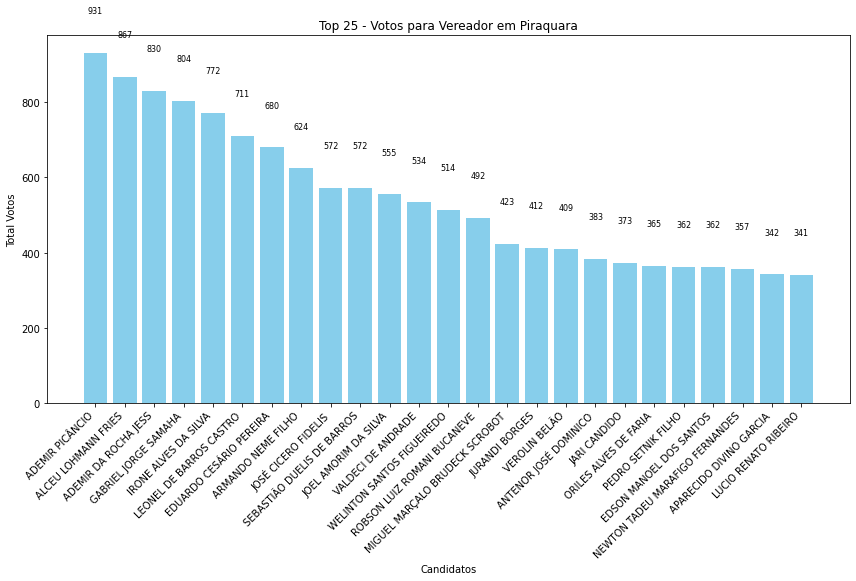

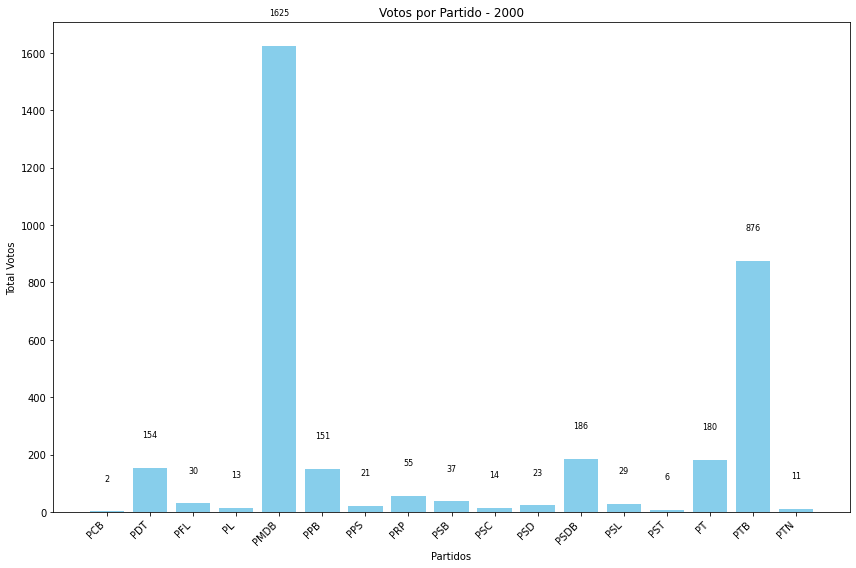

In [205]:
# Ano da Eleição
selected_year = 2000

# Cargo (Vereador ou Prefeito)
selected_cargo = 'Vereador'

# Quantidade de Candidatos
top_n_candidates = 25

# Incluir Votos Brancos e Nulos? 
include_branco_nulo = False

# Incluir votos no Partido?
include_partidos = False

# Chamada da função
plot_top_candidates(dfs[selected_year], selected_cargo, top_n_candidates, include_branco_nulo, include_partidos)
plot_votes_by_partido(dfs[selected_year], selected_year)

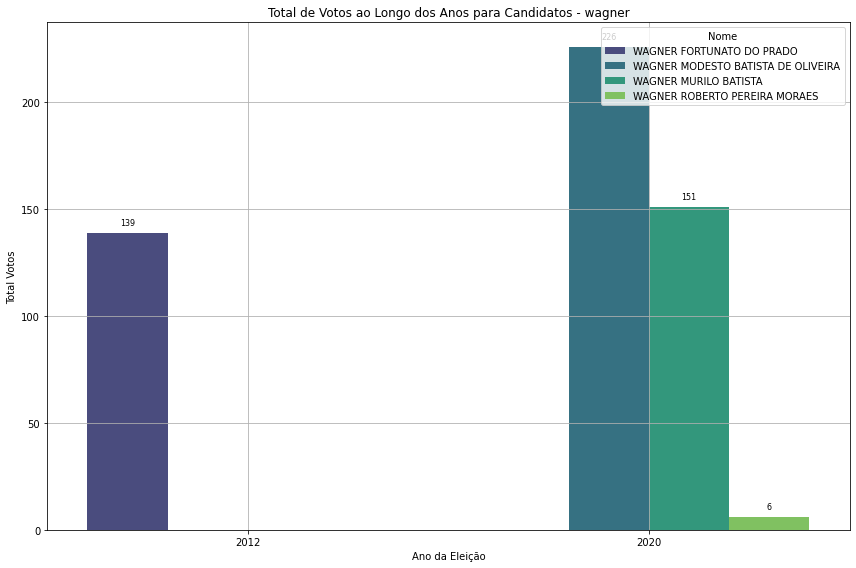

In [210]:
# Nome do Candidato
selected_candidato = 'Wagner'

plot_timeline_all_years(dfs, selected_candidato)